<a href="https://colab.research.google.com/github/subham-28/PINN-EV-Battery-Prognostics/blob/main/Experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hybrid Architecture (LSTM-PINN)

Successfully loaded 168 discharge cycles.
   Cycle  Capacity
0      2  1.856487
1      4  1.846327
2      6  1.835349
3      8  1.835263
4     10  1.834646


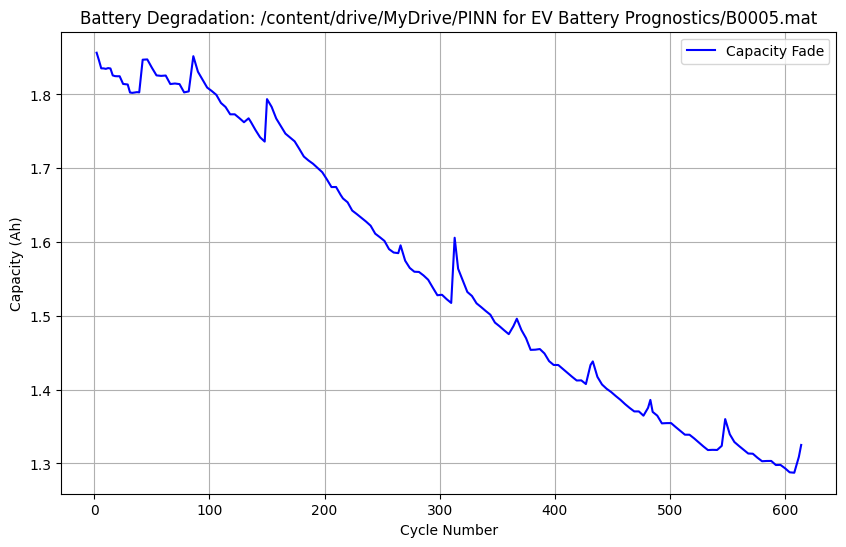

In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_nasa_data(mat_file_path):
    data = scipy.io.loadmat(mat_file_path)
    filename = mat_file_path.split('/')[-1].split('.')[0]
    batch = data[filename]
    cycles = batch[0][0]['cycle'][0]

    cycle_numbers = []
    capacities = []

    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]

        if cycle_type == 'discharge':
            try:
                capacity = cycle['data'][0][0]['Capacity'][0][0]

                cycle_numbers.append(i + 1) # Cycle count
                capacities.append(capacity) # Capacity in Amp-hours (Ah)
            except:
                pass

    df = pd.DataFrame({
        'Cycle': cycle_numbers,
        'Capacity': capacities
    })

    return df

filename = '/content/drive/MyDrive/PINN for EV Battery Prognostics/B0005.mat'

try:
    df_battery = load_nasa_data(filename)

    print(f"Successfully loaded {len(df_battery)} discharge cycles.")
    print(df_battery.head())

    # --- PLOT TO VERIFY ---
    plt.figure(figsize=(10, 6))
    plt.plot(df_battery['Cycle'], df_battery['Capacity'], 'b-', label='Capacity Fade')
    plt.xlabel('Cycle Number')
    plt.ylabel('Capacity (Ah)')
    plt.title(f'Battery Degradation: {filename}')
    plt.grid(True)
    plt.legend()
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {filename}. Please download the dataset and place it in this folder.")

In [2]:
df_battery.describe()

,Cycle,Capacity
count,168.000000,168.000000
mean,294.000000,1.572502
std,184.947314,0.190413
min,2.000000,1.287453
25%,133.000000,1.390021
50%,292.000000,1.557085
75%,454.000000,1.769163
max,614.000000,1.856487


In [3]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler_cycle=MinMaxScaler()
scaler_cap=MinMaxScaler()

In [5]:
data_cycle=scaler_cycle.fit_transform(df_battery[['Cycle']].values)
data_cap=scaler_cap.fit_transform(df_battery[['Capacity']].values)

In [6]:
#creating sliding windows as lstm needs [t-9, t-8, t-7, ..., t] to predict [t+1]
def create_window(time, capacity, window_size=10):
  x=[] #input
  y=[] #target
  t_target=[] #time for physics corresponding to target
  for i in range(len(time)-window_size):
    x.append(time[i:i+window_size])
    y.append(capacity[i+window_size])
    t_target.append(time[i+window_size])
  return np.array(x),np.array(y),np.array(t_target)


In [7]:
window_size=10
x_all,y_all,t_all=create_window(data_cycle, data_cap, window_size)
split_idx=int(len(x_all)*0.5)

In [8]:
x_train_tf=tf.convert_to_tensor(x_all[:split_idx], dtype=tf.float32)
y_train_tf=tf.convert_to_tensor(y_all[:split_idx], dtype=tf.float32)
t_train_tf=tf.convert_to_tensor(t_all[:split_idx], dtype=tf.float32)

In [9]:
x_test_tf=tf.convert_to_tensor(x_all[split_idx:], dtype=tf.float32)
y_test_tf=tf.convert_to_tensor(y_all[split_idx:], dtype=tf.float32)
t_test_tf=tf.convert_to_tensor(t_all[split_idx:], dtype=tf.float32)

In [10]:
print(f"LSTM Data Prepared!")
print(f"Input Shape: {x_train_tf.shape} (Batch, Window_Size, Features)")

LSTM Data Prepared!
Input Shape: (79, 10, 1) (Batch, Window_Size, Features)


In [16]:
class LSTMPINN(tf.keras.Model):
  def __init__(self):
    super(LSTMPINN, self).__init__()

    #building hidden layers
    self.lstm1=tf.keras.layers.LSTM(32,return_sequences=True,unroll=True)
    self.lstm2=tf.keras.layers.LSTM(32,return_sequences=False,unroll=True)

    #buidling output layer
    self.out=tf.keras.layers.Dense(1,activation=None)

    #starting the initial value of \alpha as 0.01 which is to be trained
    self.alpha=tf.Variable(0.1, dtype=tf.float32, trainable=True)

  def call(self,inputs):
    #this func return the capacity predicted for a time

    x=self.lstm1(inputs)
    x=self.lstm2(x)
    x=self.out(x)
    return x

  def physics_loss(self,inputs):

    with tf.GradientTape() as tape:
      tape.watch(inputs)
      c_pred=self.call(inputs) #capacity predicted

    #finding dc/dt
    dc_dt=tape.gradient(c_pred,inputs)
    dc_dt=dc_dt[:,-1,:]

    a = tf.abs(self.alpha)
    t_current=inputs[:,-1,:]

    residue=dc_dt+(a/(2*tf.sqrt(t_current+1e-6)))

    #finding how wrong are we from MSE
    loss_f=tf.reduce_mean(tf.square(residue))
    return loss_f

In [17]:
#initializing model
lstm_pinn = LSTMPINN()

In [18]:
#just for testing
_ = lstm_pinn(x_train_tf[:5])

In [19]:
# Separate Optimizers
opt_network = tf.keras.optimizers.Adam(learning_rate=0.005) # LSTM needs careful LR
opt_params = tf.keras.optimizers.Adam(learning_rate=0.05)   # Alpha needs fast LR

print("Starting LSTM-PINN Training...")

# Identify Variables
physics_vars = [lstm_pinn.alpha]
network_vars = [v for v in lstm_pinn.trainable_variables if v is not lstm_pinn.alpha]

history_loss = []

for epoch in range(3000):

    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        c_pred = lstm_pinn(x_train_tf)

        # Data Loss (MSE)
        loss_data = tf.reduce_mean(tf.square(c_pred - y_train_tf))

        # Physics Loss
        loss_physics = lstm_pinn.physics_loss(x_train_tf)

        # Total Loss (Weighted)
        # We use fixed weight 0.1 for stability with LSTMs
        total_loss = loss_data + (0.1 * loss_physics)

    # Compute Gradients
    grads_physics = tape.gradient(total_loss, physics_vars)
    grads_network = tape.gradient(total_loss, network_vars)
    del tape

    # Apply Updates
    opt_params.apply_gradients(zip(grads_physics, physics_vars))
    opt_network.apply_gradients(zip(grads_network, network_vars))

    history_loss.append(total_loss.numpy())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss={total_loss.numpy():.4f} | Alpha={lstm_pinn.alpha.numpy():.4f}")

print("LSTM Training Complete.")

Starting LSTM-PINN Training...
Epoch 0: Loss=0.6436 | Alpha=0.0500
Epoch 500: Loss=0.0005 | Alpha=-0.0084
Epoch 1000: Loss=0.0005 | Alpha=-0.0048
Epoch 1500: Loss=0.0005 | Alpha=-0.0020
Epoch 2000: Loss=0.0005 | Alpha=-0.0005
Epoch 2500: Loss=0.0006 | Alpha=0.0083
LSTM Training Complete.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step


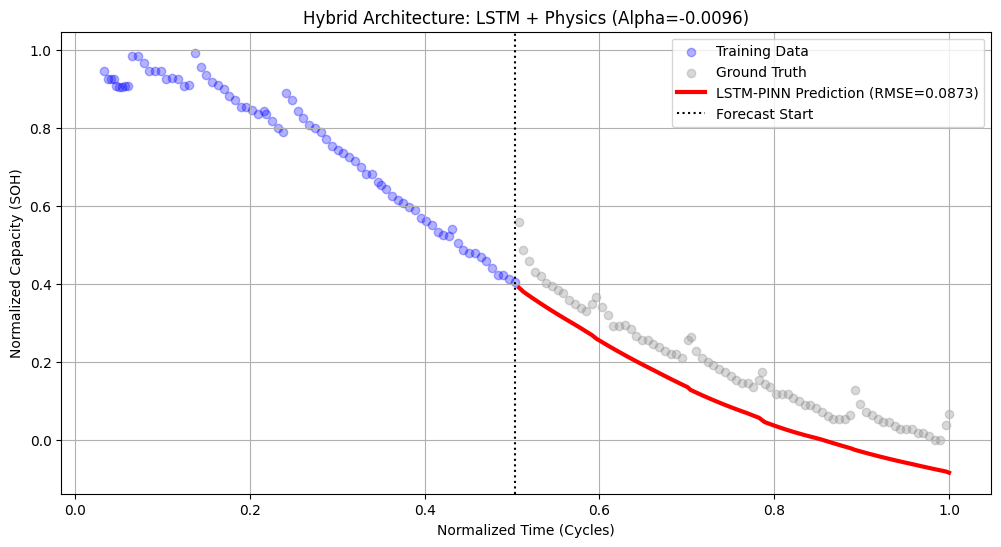

Final LSTM Hybrid RMSE: 0.0873


In [20]:
import matplotlib.pyplot as plt
import numpy as np

C_pred_lstm = lstm_pinn.predict(x_test_tf)

#rmse
rmse_lstm = np.sqrt(np.mean((y_test_tf.numpy() - C_pred_lstm)**2))

#plot
plt.figure(figsize=(12, 6))
plt.scatter(t_train_tf, y_train_tf, color='blue', alpha=0.3, label='Training Data')

plt.scatter(t_test_tf, y_test_tf, color='gray', alpha=0.3, label='Ground Truth')

plt.plot(t_test_tf, C_pred_lstm, 'r-', linewidth=3, label=f'LSTM-PINN Prediction (RMSE={rmse_lstm:.4f})')

plt.axvline(x=t_train_tf[-1], color='black', linestyle=':', label='Forecast Start')
plt.title(f"Hybrid Architecture: LSTM + Physics (Alpha={lstm_pinn.alpha.numpy():.4f})")
plt.xlabel("Normalized Time (Cycles)")
plt.ylabel("Normalized Capacity (SOH)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final LSTM Hybrid RMSE: {rmse_lstm:.4f}")